In [1]:
from re import S
from typing import final
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

# from MD_AE_model import *
from model_no_bias import *

import myplot

import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

import time
import os
import configparser
import datetime
import wandb

# get system information
config = configparser.ConfigParser()
config.read('__system.ini')
system_info = config['system_info']

# use gpu
if system_info.getboolean('GPU'):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)

3 Physical GPUs, 1 Logical GPU


2022-05-19 09:28:31.550882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 09:28:32.087165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47203 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:a6:00.0, compute capability: 7.5


In [2]:
%matplotlib inline

In [3]:
# data
data_file = './PIV4_downsampled_by8.h5'
Ntrain = 1500 # snapshots for training
Nval = 632 # sanpshots for validation
Ntest = 600

# Boolean 
LATENT_STATE = True # save latent state
SHUFFLE = True # shuffle before splitting into sets, test set is extracted before shuffling
REMOVE_MEAN = True # train on fluctuating velocity

## ae configuration
lmb = 0.001 #1e-05 #regulariser
drop_rate = 0.2
features_layers = [32, 64, 128]
latent_dim = 10
act_fct = 'linear'
resize_meth = 'bilinear'
filter_window= (3,3)
batch_norm = True

## training
nb_epoch = 1000
batch_size = 100
learning_rate = 0.001
learning_rate_list = [learning_rate,learning_rate/10,learning_rate/100] #[0.001,0.0001,0.00001]

In [4]:
#================================= IMPORT DATA ==========================================================
Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 

print('Reading dataset from :' + data_file)
hf = h5py.File(data_file,'r')

z = np.array(hf.get('z'))
y = np.array(hf.get('y'))
u_all = np.zeros((Nt,Nz,Ny,Nu))
u_all[:,:,:,0] = np.array(hf.get('vy'))
if Nu==2:
    u_all[:,:,:,1] = np.array(hf.get('vz'))
u_all = np.transpose(u_all,[0,2,1,3]) # shape of u_all = (Nt,Ny,Nz,Nu)
hf.close()

#=================================== DEFINE TRAINING ==========================================
u_all = u_all[:,:,:,:].astype('float32')

# remove mean for modes
if REMOVE_MEAN:
    u_mean_all = np.mean(u_all,axis=0) # time averaged, (Ny,Nz,Nu)
    u_all = u_all - u_mean_all


if SHUFFLE:
    # temp_list = list(u_all)
    # np.random.shuffle(temp_list) # this shuffles the first axis
    # u_all = np.array(temp_list)

    idx_test = np.random.randint(0,Nt-Ntest)
    u_test = u_all[idx_test:idx_test+Ntest,:,:,:].astype('float32') # test set needs to be in order and has continuous snapshots
    u_all = np.delete(u_all,np.s_[idx_test:idx_test+Ntest],0) # remove the test set from available samples
    idx_shuffle = np.arange(Nt-Ntest) # use idx_shuffle to shuffle the rest of samples before taking a validation set
    np.random.shuffle(idx_shuffle)
    idx_unshuffle = np.argsort(idx_shuffle) # use idx_unshuffle to unshuffle the data
    u_all = u_all[idx_shuffle,:,:,:]
    u_train = u_all[0:Ntrain,:,:,:].astype('float32')
    u_val = u_all[Ntrain:Ntrain+Nval,:,:,:].astype('float32')
    u_all = np.vstack((u_train,u_val,u_test))
else:
    u_train = u_all[0:Ntrain,:,:,:].astype('float32')
    u_val = u_all[Ntrain:Ntrain+Nval,:,:,:].astype('float32')
    u_test = u_all[Ntrain+Nval:Ntrain+Nval+Ntest,:,:,:].astype('float32')
    u_all = u_all[0:Ntrain+Nval+Ntest,:,:,:].astype('float32') # u_all has shape (Ntrain+Nval+Ntest,Ny,Nz,Nu)


# u_train = u_all[0:Ntrain,:,:,:].astype('float32')
# u_val = u_all[Ntrain:Ntrain+Nval,:,:,:].astype('float32')
# u_test = u_all[Ntrain+Nval:Ntrain+Nval+Ntest,:,:,:].astype('float32')
# u_all = u_all[0:Ntrain+Nval+Ntest,:,:,:].astype('float32') # u_all has shape (Ntrain+Nval+Ntest,Ny,Nz,Nu)

u_all = np.reshape(u_all,(1,Ntrain+Nval+Ntest,Ny,Nz,Nu)) # new shape (1,Nval+Ntrain+Ntest,Ny,Nz,Nu)
u_train = np.reshape(u_train,(1,Ntrain,Ny,Nz,Nu))
u_val = np.reshape(u_val,(1,Nval,Ny,Nz,Nu))
u_test = np.reshape(u_test,(1,Ntest,Ny,Nz,Nu))
Nx = [Ny, Nz]

Reading dataset from :./PIV4_downsampled_by8.h5


In [5]:
ae = Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,act_fct=act_fct,batch_norm=batch_norm,
        drop_rate=drop_rate, lmb=lmb)

In [6]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21, 24, 2)]       0         
                                                                 
 encoder (Encoder)           (None, 10)                105152    
                                                                 
 decoder (Decoder)           (None, 21, 24, 2)         109248    
                                                                 
Total params: 214,400
Trainable params: 211,456
Non-trainable params: 2,944
_________________________________________________________________


In [7]:
#================================================ TRAINING ==========================================
ae.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse') # or use tf.keras.losses.MeanAbsoluteError()
pat = 100 # patience for EarlyStopping

# Early stopping
hist_train = []
hist_val = []
tempfn = './temp_md_autoencoder.h5'
model_cb=ModelCheckpoint(tempfn, monitor='val_loss',save_best_only=True,verbose=0,save_weights_only=True)
early_cb=EarlyStopping(monitor='val_loss', patience=pat,verbose=1)
cb = [model_cb, early_cb]

# Training
print('Training...')
for i in range(len(learning_rate_list)):
    learning_rate = learning_rate_list[i]
    K.set_value(ae.optimizer.lr,learning_rate)
    hist0 = ae.fit(u_train[0,:,:,:,:], u_train[0,:,:,:,:],
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(u_val[0,:,:,:,:], u_val[0,:,:,:,:]),
                    callbacks=cb,verbose=0)  
    ae.load_weights(tempfn)
    hist_train.extend(hist0.history['loss'])
    hist_val.extend(hist0.history['val_loss'])
print('Finished training')

Training...


2022-05-19 09:29:00.061202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400
2022-05-19 09:29:00.947061: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 00315: early stopping
Epoch 00101: early stopping
Finished training


In [8]:
latent_test = ae.encoder.predict(u_test[0,:,:,:,:])
y_test = ae.predict(u_test[0,:,:,:,:])
loss_test_1 = ae.evaluate(u_test[0,:,:,:,:],u_test[0,:,:,:,:],verbose=1)
loss_test_2 = tf.keras.losses.MeanSquaredError()(u_test[0,:,:,:,:],y_test)
print(loss_test_1,loss_test_2.numpy())

19/19 [==============================] - 0s 7ms/step - loss: 1.2290
1.2289924621582031 1.215594


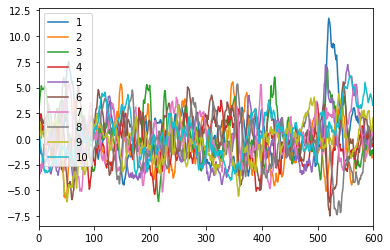

In [16]:
plt.figure()
for z in range(latent_dim):
    plt.plot(latent_test[:,z],label=str(z+1))
plt.xlim([0,600])
plt.legend()
plt.show()

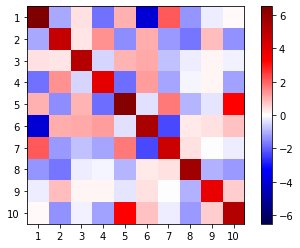

variance [ 1  5  8  6 10  3  2  7  4  9]
covariance sum [ 1  5  6  2  7  4 10  8  3  9]
determinant of corr matrix:  0.042541022327016564


In [45]:
cov = latent_test.T@latent_test/600
# cov = np.cov(latent_test.T)
vmax = np.max(cov)
plt.figure()
plt.imshow(cov,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov))
rank_var = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance',rank_var)

covar_sum = np.sum(abs(cov-np.diag(np.diag(cov))),axis=0)
sort_idx = np.argsort(covar_sum)
rank_cov = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('covariance sum',rank_cov)

det = np.linalg.det(np.corrcoef(latent_test.T))
print('determinant of corr matrix: ',det) 

In [11]:
linear_modes = []

for i in range(latent_dim):
    single = np.zeros_like(latent_test)
    single[:,i] = latent_test[:,i]
    linear_modes.append(ae.decoder.predict(single))

linear_modes = np.array(linear_modes)

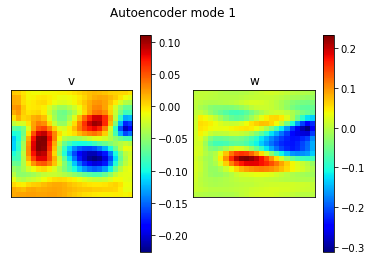

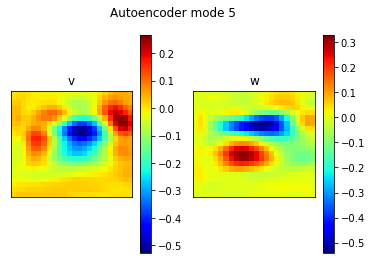

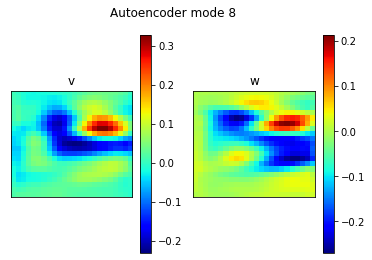

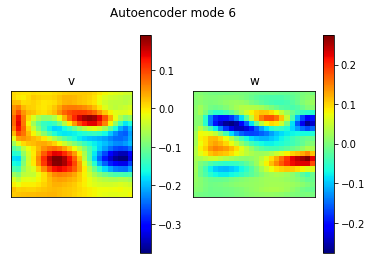

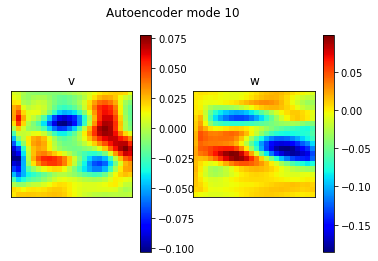

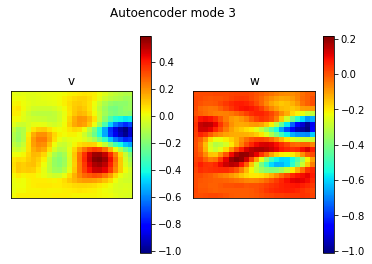

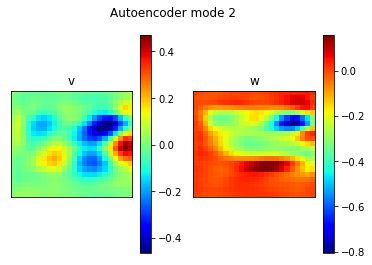

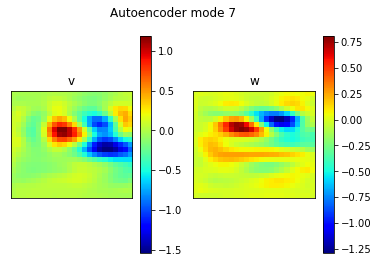

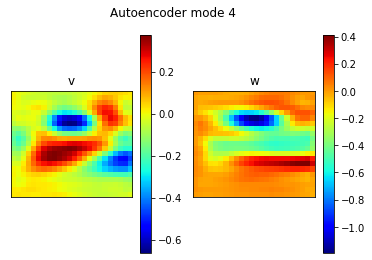

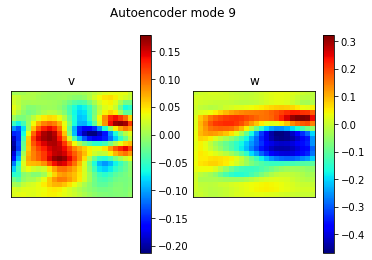

In [36]:
myplot.plot_ae_modes(linear_modes,[0,4,7,5,9,2,1,6,3,8],snapshot=0)

In [20]:
import mode_decomposition as md

Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.


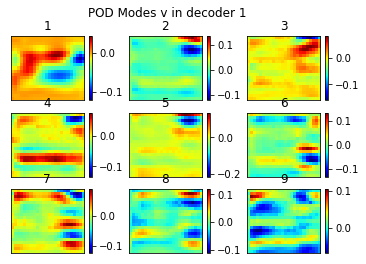

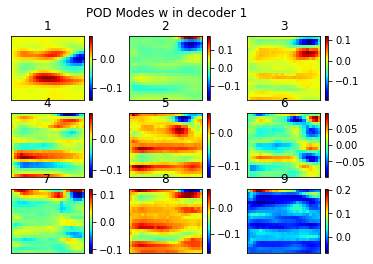

spectrum (first 5):  [1. 1. 1. 1. 1.]


In [30]:
## build matrix

which_decoder = 1-1
PlotWhichVelocity = 'v' 
save_img = False
vy = linear_modes[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = linear_modes[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean
# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs
## plot POD
fig = plt.figure(1)
title = "POD Modes " + PlotWhichVelocity + " in decoder " + str(which_decoder+1)
# title = "POD Modes "+PlotWhichVelocity
plt.suptitle(title)
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    if PlotWhichVelocity == 'w': # Q was built [vz,vy]
        pltV = pltV[0:Ny,:]
    elif PlotWhichVelocity == 'v':
        pltV = pltV[Ny:,:]
    elif PlotWhichVelocity == 'V':
        pltV = (pltV[0:Ny,:]**2 + pltV[Ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
PlotWhichVelocity = 'w' 
fig = plt.figure(2)
title = "POD Modes " + PlotWhichVelocity + " in decoder " + str(which_decoder+1)
# title = "POD Modes "+PlotWhichVelocity
plt.suptitle(title)
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    if PlotWhichVelocity == 'w': # Q was built [vz,vy]
        pltV = pltV[0:Ny,:]
    elif PlotWhichVelocity == 'v':
        pltV = pltV[Ny:,:]
    elif PlotWhichVelocity == 'V':
        pltV = (pltV[0:Ny,:]**2 + pltV[Ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

plt.show()

## Spectrum
energy = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy[:5])